# The Variational Quantum Linear Solver for Redundant Calibration

In [1]:
import qiskit
from qiskit import QuantumCircuit, QuantumRegister, ClassicalRegister
from qiskit.quantum_info.operators import Operator
from qiskit import Aer, transpile, assemble
import math
import random
import numpy as np
from scipy.optimize import minimize

from vqls_redcal_utils import get_antnennas_response

## 1. Redundant Calibration

We consider here the case of 5 antennas that are positionned in a row. The positions of the antennas are given by :

In [2]:
n_ant = 5
xpos = np.linspace(-2, 2, n_ant)[:,None]

The magnitude matrix is in this case given by :

In [3]:
Mmag = np.matrix(
    [[1, 1, 0, 0, 0, 1, 0, 0],     # baseline type 1 (4 rows)
     [0, 1, 1, 0, 0, 1, 0, 0],
     [0, 0, 1, 1, 0, 1, 0, 0],
     [0, 0, 0, 1, 1, 1, 0, 0],
     [1, 0, 1, 0, 0, 0, 1, 0],     # baseline type 2 (3 rows)
     [0, 1, 0, 1, 0, 0, 1, 0],
     [0, 0, 1, 0, 1, 0, 1, 0],
     [1, 0, 0, 1, 0, 0, 0, 1],     # baseline type 3 (2 row)
     [0, 1, 0, 0, 1, 0, 0, 1],
     [1, 0, 0, 0, 0, 0, 0, 0]])    # magnitude constraint

The redundant calibration is then reduced to solving the least square problem [https://arxiv.org/pdf/1004.0156.pdf]

$$
M_{mag} \theta = b
$$

where $b$ is given by the response of the antennas. For convenience we have packaged that response in a small method 

In [4]:
b = get_antnennas_response(xpos)

## 2. Variational Quantum Linear Solver

The Variational Quantum Linear Solver, or the VQLS is a variational quantum algorithm that utilizes VQE in order to solve systems of linear equations more efficiently than classical computational algorithms. Specifically, if we are given some matrix $\textbf{A}$, such that $\textbf{A} |\textbf{x}\rangle \ = \ |\textbf{b}\rangle$, where $|\textbf{b}\rangle$ is some known vector, the VQLS algorithm is theoretically able to find a normalized $|x\rangle$ that is proportional to $|\textbf{x}\rangle$, which makes the above relationship true.

The output of this algorithm is identical to that of the HHL Quantum Linear-Solving Algorithm, except, while HHL provides a much more favourable computation speedup over VQLS, the variational nature of our algorithm allows for it to be performed on NISQ quantum computers, while HHL would require much more robust quantum hardware, and many more qubits.

The details of the algorithm can be found in the original paper :

"Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems", written by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles, which is available at [this](https://arxiv.org/abs/1909.05820) link.

And this implementation is largely based on the Qiskit tutorial

https://qiskit.org/textbook/ch-paper-implementations/vqls.html



## 3. Adapting the Redcal problem to VQLS

One of the main complication of VQLS for redundant calibration is that the matrix $\textbf{A}$ must be decomposed as a sum of unitary matrices :

$$A \ = \ \displaystyle\sum_{n} c_n \ A_n$$

The matrix $M_{mag}$ is not even square which makes it difficult to 
apply VQLS to Redcal.

### Transforming a least square to a linear system

In order to be able to use VQLS for redundant calibration we can manipulate our least square problem as followed :

$$ M_{mag} \theta = b $$

Multiplying on both sides by $M_{mag}^{\dagger}$ one obtain:

$$ M_{mag}^{\dagger} M_{mag} \theta = M_{mag}^{\dagger} b $$

The matrix $A = M_{mag}^{\dagger} M_{mag}$ is now symmetric which is a good start to find a unitary decomposition of it. One then  obtain the linear system

$$ A \theta = \tilde{b} $$

with $\tilde{b} = M_{mag}^{\dagger} b$

In [5]:
A = Mmag.T@Mmag
print(A)

[[4 1 1 1 0 1 1 1]
 [1 4 1 1 1 2 1 1]
 [1 1 4 1 1 2 2 0]
 [1 1 1 4 1 2 1 1]
 [0 1 1 1 3 1 1 1]
 [1 2 2 2 1 4 0 0]
 [1 1 2 1 1 0 3 0]
 [1 1 0 1 1 0 0 2]]


In [6]:
btilde = Mmag.T@b
print(btilde)

[[-0.29071421]
 [-0.73695686]
 [-0.98960915]
 [-0.25177687]
 [ 0.02364886]
 [-1.2091614 ]
 [-0.42849588]
 [ 0.51495317]]


### Unitary decomposition 

Unitary decomposition of matrices is currently an active topic of research given the importance of such decompoisition in quantum computing See for example [this](https://arxiv.org/pdf/2101.02993.pdf).

While it is difficult at the moment to find the best decomposition of our matrix $A$, we can rely for the moment on techniques explained [here](https://math.stackexchange.com/questions/1710247/every-matrix-can-be-written-as-a-sum-of-unitary-matrices/1710390#1710390), to decompose our matrix in 4 unitary matrices.

In this example the contribution of the last two matrices cancel each other and we can therefore limit the decomposition to the 2 unitary matrices

In [7]:
from unitary_decomp import unitary_decomposition, unitary_recomposition
coeffs_An, An = unitary_decomposition(A)
coeffs_An, An = coeffs_An[:2], An[:2]
print(unitary_recomposition(coeffs_An, An))

[[4.+0.j 1.+0.j 1.+0.j 1.+0.j 0.+0.j 1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 4.+0.j 1.+0.j 1.+0.j 1.+0.j 2.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 1.+0.j 4.+0.j 1.+0.j 1.+0.j 2.+0.j 2.+0.j 0.+0.j]
 [1.+0.j 1.+0.j 1.+0.j 4.+0.j 1.+0.j 2.+0.j 1.+0.j 1.+0.j]
 [0.+0.j 1.+0.j 1.+0.j 1.+0.j 3.+0.j 1.+0.j 1.+0.j 1.+0.j]
 [1.+0.j 2.+0.j 2.+0.j 2.+0.j 1.+0.j 4.+0.j 0.+0.j 0.+0.j]
 [1.+0.j 1.+0.j 2.+0.j 1.+0.j 1.+0.j 0.+0.j 3.+0.j 0.+0.j]
 [1.+0.j 1.+0.j 0.+0.j 1.+0.j 1.+0.j 0.+0.j 0.+0.j 2.+0.j]]


### Creation of the $\tilde{b}$ vector

VQLS aslo require an operator that creates the rhs of the linear system from the $|0\rangle$ state. In other words we define an operator $U_b$ so that :

$$
U_b|0\rangle = |\tilde{b}\rangle
$$

We do that by using Qiskit to create a circuit, initialize the state of the circuit to $|\tilde{b}\rangle$ and extract the matrix of the circuit. There might be better ways of doing this.

In [8]:
from get_b import get_b_unitmatrix
norm_btilde, Ub_mat = get_b_unitmatrix(btilde, 3, decimals=12)
print(Ub_mat)

[[-0.15360961+0.j  0.38939842-0.j  0.1979946 +0.j -0.50191381+0.j
   0.16432128+0.j -0.41655237+0.j -0.21180137+0.j  0.53691381-0.j]
 [-0.38939842-0.j -0.15360961+0.j  0.50191381+0.j  0.1979946 +0.j
   0.41655237+0.j  0.16432128+0.j -0.53691381-0.j -0.21180137+0.j]
 [-0.52289661+0.j  0.13303562-0.j -0.40567744+0.j  0.10321266-0.j
   0.5593598 -0.j -0.14231261+0.j  0.43396658-0.j -0.11041   +0.j]
 [-0.13303562-0.j -0.52289661-0.j -0.10321266-0.j -0.40567744-0.j
   0.14231261+0.j  0.5593598 +0.j  0.11041   +0.j  0.43396658+0.j]
 [ 0.01249575+0.j -0.63890516-0.j -0.00692173-0.j  0.35390645+0.j
   0.01168118+0.j -0.59725661-0.j -0.00647052-0.j  0.33083621+0.j]
 [-0.63890516+0.j -0.01249575+0.j  0.35390645+0.j  0.00692173-0.j
  -0.59725661+0.j -0.01168118+0.j  0.33083621+0.j  0.00647052-0.j]
 [-0.22641165-0.j  0.27209455+0.j -0.40873958-0.j  0.49121065+0.j
  -0.21165247-0.j  0.25435743+0.j -0.38209492-0.j  0.45918992+0.j]
 [ 0.27209455+0.j  0.22641165+0.j  0.49121065+0.j  0.40873958+0.j
   

## 4. Qiskit Implementation

### Wave function Ansatz

VQLS works by optimizing a wave function ansatz $|\psi(\alpha)\rangle$ that depends on variational parameters $\alpha$ and that should approximate the solution of the linear system, i.e. $|\psi(\alpha)\rangle\approx|\theta\rangle$ in our case.

The creation of this wave function ansatz is done through a module $V(\alpha)$ that acts as follows:

$$
V(\alpha)|0\rangle = |\psi(\alpha)\rangle
$$

Many possibilities exists to define $V(\alpha)$. We use here a simple module described in the original paper

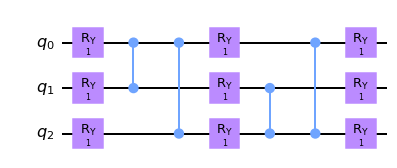

In [9]:
from vqls_redcal_utils import apply_fixed_ansatz
circ = QuantumCircuit(3)
apply_fixed_ansatz(circ, [0, 1, 2], [[1, 1, 1], [1, 1, 1], [1, 1, 1]])
circ.draw(output='mpl')

### Hadamard Test

VQLS relies on the Hadammard test to compute terms such as 

$$\langle \Phi | \Phi \rangle \ = \ \langle \psi(k) | A^{\dagger} A |\psi(k) \rangle \ = \ \langle 0 | V(k)^{\dagger} A^{\dagger} A V(k) |0\rangle \ = \ \langle 0 | V(k)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big)^{\dagger} \Big( \displaystyle\sum_{n} c_n \ A_n \Big) V(k) |0\rangle$$



<br>



$$\Rightarrow \ \langle \Phi | \Phi \rangle \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m^{*} c_n \langle 0 | V(k)^{\dagger} A_m^{\dagger} A_n V(k) |0\rangle$$

As explained in the original paper the hadamard test uses an auxiliary qbit that controls the applications of the $A_n$ and $A_m^\dagger$ operators, in other words:

$$
A_m |0\rangle|\psi(\alpha) = |0\rangle|\psi(\alpha)\rangle
$$

and

$$
A_m |1\rangle|\psi(\alpha) = |1\rangle A_m|\psi(\alpha)\rangle
$$

We therefore need to define these controlled operators for the $A_n$ matrices and their conjugate transpose

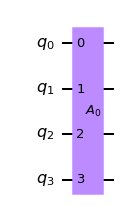

In [10]:
from vqls_redcal_utils import get_controlled_operator_matrix, apply_controlled_gate

ctrl_An = get_controlled_operator_matrix(An, 0, [1,2,3])
ctrl_An_name = ['$A_0$', '$A_1$']

ctrl_An_dagger = get_controlled_operator_matrix([np.conjugate(a).T for a in An], 0, [1,2,3])
ctrl_An_dagger_name = ['$A_0^\dagger$', '$A_1^\dagger$']

circ = QuantumCircuit(4)
apply_controlled_gate(circ, ctrl_An[0], 0, [1,2,3], name=ctrl_An_name[0])
circ.draw(output='mpl')

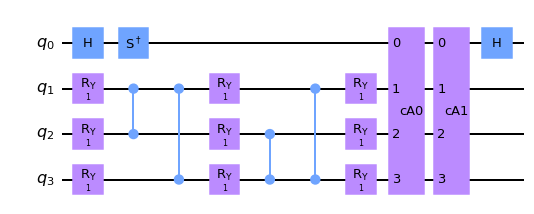

In [11]:
# Creates the Hadamard test
from vqls_redcal_utils import hadammard_test
circ = QuantumCircuit(4)
hadammard_test(circ, [ctrl_An[0], ctrl_An_dagger[1]],  ['cA0', 'cA1'], 
               [1, 2, 3], 0, [[1, 1, 1], [1, 1, 1], [1, 1, 1]], imag=True)
circ.draw(output='mpl')

### Computing  $|\langle b | \Phi \rangle|^2$

VQLS also relies on the calculation of the term :

$$|\langle b | \Phi \rangle|^2 \ = \ \displaystyle\sum_{m} \displaystyle\sum_{n} c_m c_n \langle 0 | U^{\dagger} A_n V(k) | 0 \rangle \langle 0 | U^{\dagger} A_m V(k) | 0 \rangle$$


There is a sophisticated way of solving for this value, using a newly-proposed subroutine called the **Hadamard Overlap Test** (see cited paper), but we will just be using a standard Hadamard Test, where we control each matrix. This unfortunately requires the use of an extra auxiliary qubit. We essentially just place a control on each of the gates involved in the auxiliary, the $|b\rangle$ preparation unitary, and the $A_n$ unitaries. 

We already have the controlled version of the $A_n$ operators. The circuit of the **controlled** wave function ansatz can be obtained via : 


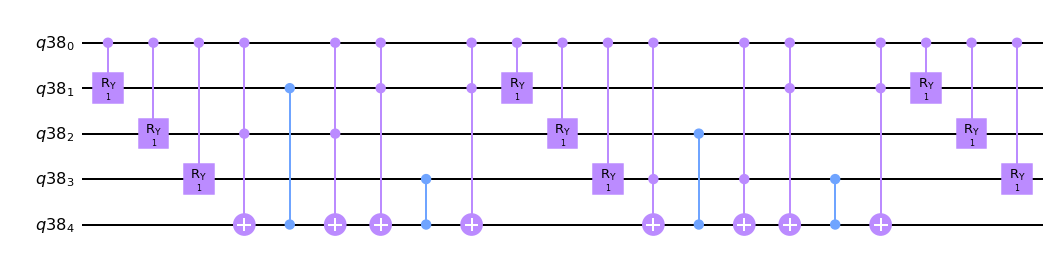

In [12]:
# Creates controlled anstaz for calculating |<b|psi>|^2 with a Hadamard test
from vqls_redcal_utils import apply_control_fixed_ansatz
q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
apply_control_fixed_ansatz(circ, [1, 2, 3], [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 0, q_reg)
circ.draw(output='mpl')

The circuit that make a controlled application of the right hand side operator is obtained in the same way as the controlled version of the $A_n$ matrices:

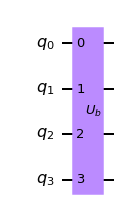

In [13]:
ctrl_Ub_mat = get_controlled_operator_matrix([Ub_mat], 0, [1,2,3])[0].real
ctrl_Ub_mat_dagger = get_controlled_operator_matrix([Ub_mat.T], 0, [1,2,3])[0].real

circ = QuantumCircuit(4)
apply_controlled_gate(circ, ctrl_Ub_mat, 0, [1,2,3], name='$U_b$')
circ.draw(output='mpl')

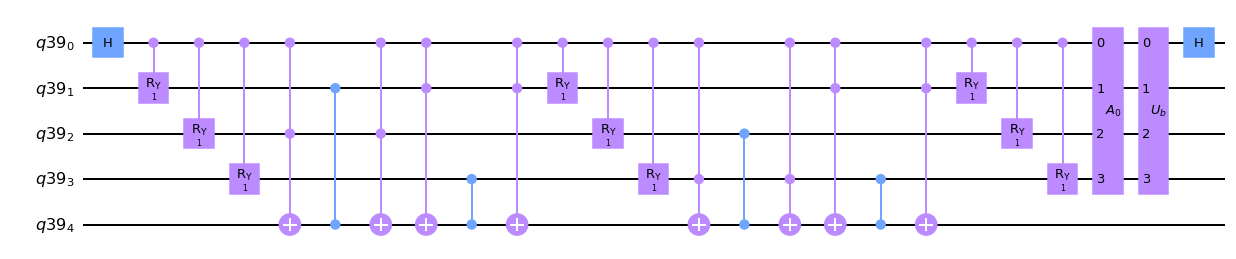

In [14]:
from vqls_redcal_utils import special_hadammard_test

q_reg = QuantumRegister(5)
circ = QuantumCircuit(q_reg)
special_hadammard_test(circ, ctrl_An[0], '$A_0$', ctrl_Ub_mat, 
                       [1, 2, 3], 0, 
                       [[1, 1, 1], [1, 1, 1], [1, 1, 1]], 
                       q_reg)
circ.draw(output='mpl')

### Computing the cost function of the optimization process.

We now have to compute the cost function of the VQLS circuit. This is rather convoluted and has been wrapped in the function `calculate_cost_function` that we can use with the `scipy.minimize` method.

In [15]:
from vqls_redcal_utils import calculate_cost_function


sum_coefficient = np.sum(coeffs_An)
coeffs_An = [c/sum_coefficient for c in coeffs_An]

out = minimize(calculate_cost_function, 
               x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], 
               args = (ctrl_An, ctrl_An_name,
                       ctrl_An_dagger, ctrl_An_dagger_name, 
                       coeffs_An, 
                       ctrl_Ub_mat_dagger),
               method="COBYLA", options={'maxiter':200, 'disp':False})
print(out)


(0.9711531573684242+3.536648258830766e-16j)
(0.9706186625976733+6.546188412399046e-16j)
(0.6406958665473663+1.0019695609443475e-14j)
(0.9925401273372394+1.4052522756396184e-16j)
(0.38082845783937935+5.5522691095569465e-15j)
(0.6017494820577449+1.5231041815813762e-14j)
(0.6839399350506457-1.2747825425050585e-14j)
(0.26619430856620285+1.715202672695543e-14j)
(0.17078289768210986+6.422018670631321e-16j)
(0.5044088559981413-5.590191791871599e-16j)
(0.10670438030229401+5.490676877329208e-15j)
(0.1256983263185294+1.982147786457705e-15j)
(0.15135603318030177+1.0763231338724335e-14j)
(0.13028549896829378+7.972347111322271e-15j)
(0.10324643815484857-3.182187500368244e-15j)
(0.12423545252654444-4.772288848511651e-15j)
(0.15150082464285142-1.598580588237403e-15j)
(0.13692145983673765-2.4582326900154195e-15j)
(0.20657106387569657-2.5316669765780327e-15j)
(0.09833039023312784-3.1857905266703877e-15j)
(0.10928821041451087+2.081419519196968e-15j)
(0.039156613609507174+7.236960127327056e-15j)
(0.02312

(0.0018095853966042519+1.0689614496020791e-14j)
(0.0018344279771546068+1.0184932315671492e-15j)
(0.0017910350827948784+6.348120316272611e-15j)
(0.0017460900281118796+3.558862701355952e-15j)
(0.0016962718650695985+3.293370391010341e-15j)
(0.0016612041886131523+6.350701867055966e-15j)
(0.0016282038781645358-3.569859484433123e-15j)
(0.00158592523207024+4.584462471840177e-15j)
(0.001561822533975521+4.3029112217266865e-15j)
(0.0015385293545158163+4.041013301554298e-15j)
(0.001505771335232442+1.0342933689241659e-14j)
(0.0014722710162938801+3.791657530792651e-15j)
(0.0015084804458079804+4.279000773912949e-15j)
(0.0014797379755998596+7.581229893926877e-15j)
(0.0014331035952506177+4.316288907034591e-15j)
(0.0014058720552200255+6.6105534469397895e-15j)
(0.0013902145814582711+5.5793232845930885e-15j)
(0.0013620545373503878+2.271850844170048e-15j)
(0.0013625593343914444+1.7553027257643317e-15j)
(0.0013532219460153927-5.049521827946377e-16j)
(0.0013706434762424946+7.870835859113746e-15j)
(0.0013629

### Checking the solution

We can now check if the solution is any good. We first get the state vector of the optimized circuit

In [16]:
out_f = [out['x'][0:3], out['x'][3:6], out['x'][6:9]]

circ = QuantumCircuit(3, 3)
apply_fixed_ansatz(circ, [0, 1, 2], out_f)
circ.save_statevector()

backend = Aer.get_backend('aer_simulator')
t_circ = transpile(circ, backend)
qobj = assemble(t_circ)
job = backend.run(qobj)

result = job.result()
o = result.get_statevector(circ, decimals=10)

Then compute some metrics

residue: 2.6038141035406057
rms: (0.17815750343706974+0j)


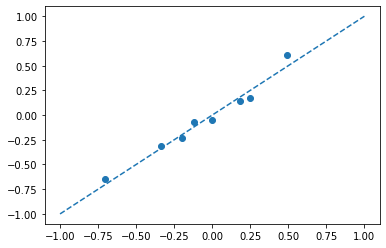

In [33]:
Atmp = unitary_recomposition(coeffs_An, An).real
rhs = btilde/np.linalg.norm(btilde)

x = np.linalg.solve(Atmp,rhs)
norm_x = np.linalg.norm(x)
x /= norm_x
x = np.asarray(x).flatten().real

res = np.linalg.norm(Atmp@o-rhs)
print('residue:', res)

print('rms:', np.sqrt(np.sum( (o-x)**2 )) )
import matplotlib.pyplot as plt
plt.scatter(x,o.real)
plt.plot([-1,1],[-1,1],'--')

### Sample the output of the circuit

Now, we have found that this algorithm works **in theory**. I tried to run some simulations with a circuit that samples the circuit instead of calculating the probabilities numerically. Now, let's try to **sample** the quantum circuit, as a real quantum computer would do! For some reason, this simulation would only converge somewhat well for a ridiculously high number of "shots" (runs of the circuit, in order to calculate the probability distribution of outcomes). I think that this is mostly to do with limitations in the classical optimizer (COBYLA), due to the noisy nature of sampling a quantum circuit (a measurement with the same parameters won't always yield the same outcome). Luckily, there are other optimizers that are built for noisy functions, such as SPSA, but we won't be looking into that in this tutorial. Let's try our sampling for our second value of $A$, with the same matrix $U$:

In [18]:
from vqls_redcal_utils import sample_cost_function


sum_coefficient = np.sum(coeffs_An)
coeffs_An = [c/sum_coefficient for c in coeffs_An]

out = minimize(sample_cost_function, 
               x0=[float(random.randint(0,3000))/1000 for i in range(0, 9)], 
               args = (ctrl_An, ctrl_An_name,
                       ctrl_An_dagger, ctrl_An_dagger_name, 
                       coeffs_An, 
                       ctrl_Ub_mat_dagger),
               method="COBYLA", options={'maxiter':200, 'disp':True})
print(out)

(0.15058105800352095+1.724170051913933j)


/home/nico/anaconda3/envs/qbit/lib/python3.8/site-packages/scipy/optimize/cobyla.py:260: ComplexWarning: Casting complex values to real discards the imaginary part
  xopt, info = _cobyla.minimize(calcfc, m=m, x=np.copy(x0), rhobeg=rhobeg,


(0.09937330472731365+1.786261163130524j)
(0.08728247484331741+1.7992193575594415j)
(0.06452770668571162+1.818217791702514j)
(-0.0025106350890666818+1.834690830598243j)
(-0.009830188546392948+1.8374525440470075j)
(-0.0067354758641473556+1.8402571214384453j)
(-0.024123746730185358+1.8306276541960513j)
(0.02263808021208269+1.8323649352092402j)
(0.022852331990402597+1.8289639392929835j)
(-0.03872089701021353+1.826537760229491j)
(-0.04463505978410054+1.827441427338333j)
(-0.04205721748124436+1.8269304507008257j)
(-0.03992136104617394+1.8225284070949468j)
(-0.022434081897515945+1.8302455624339198j)
(-0.039795999684035355+1.8345815107931516j)
(-0.042389090734734625+1.8247239907303694j)
(-0.053875134535484426+1.8270686549503805j)
(-0.0360599358581275+1.8302193026207205j)
(-0.05618968928935186+1.8351232826675916j)
(-0.0506087983029746+1.8310569951530116j)
(-0.0313530731574585+1.8412645591727683j)
(-0.047254930047741395+1.8361081685887868j)
(-0.053081189021224384+1.8320682468801026j)
(-0.0379523



## 4. Acknowledgements

This implementation is based on the work presented in the research paper "Variational Quantum Linear Solver: A Hybrid Algorithm for Linear Systems", written by Carlos Bravo-Prieto, Ryan LaRose, M. Cerezo, Yiğit Subaşı, Lukasz Cincio, and Patrick J. Coles, which is available at [this](https://arxiv.org/abs/1909.05820) link.

Special thanks to Carlos Bravo-Prieto for personally helping me out, by answering some of my questions concerning the paper!

In [19]:
import qiskit.tools.jupyter
%qiskit_version_table